In [19]:
#% pip install openpyxl
import pandas as pd
import sklearn as sk
import matplotlib.pyplot as plt
import numpy as np
import sys
from __globals import *
from _utilities import plot_scatter, prepare_database
sys.path.append("../tools/")
import _db_tools as db
####Helper Functions####
def RyR(df):
    """Calculates and prints the RyR values for both fibers, including a cualitative evaluation"""
    i = 0; df_RyR = [] #Preallocate a counter and an empty dataframe where to add the rows
    std = df.iloc[:, :-2].std(axis=1) #Standard deviation for each row, excluding limits
    for index in range(df.shape[0]):
        i+= 1
        RyR = (6*std.iloc[index]/(df.iloc[index,-1]-df.iloc[index,-2]))*100 #Calculates RyR for the whole dataframe
        df_RyR.append(float(RyR)) #Adds the values of RyR to a ndarray
    df_RyR = pd.DataFrame(df_RyR) #Builds a new dataframe with the RyR values
    x_fiber = df_RyR[df_RyR.index % 2 != 0] #Indexes the fiber x RyR values in a new dataframe
    y_fiber = df_RyR[df_RyR.index % 2 == 0] #Indexes the fiber y RyR values in a new dataframe
    dfx = pd.DataFrame(x_fiber).reset_index(drop=True) #Resets row index
    dfy = pd.DataFrame(y_fiber).reset_index(drop=True) #Resets row index
    for i, _ in enumerate(range(dfx.shape[0])): #Prints the dataframe for fiber x row by row indexing with the counter
        Pass = "Correct" if dfx.iloc[i, 0] <= 10 else ("Low fail" if 10 <= dfx.iloc[i, 0] <= 25 else "High fail")
        print(f'RyR Guide fbx {dfx.index[i]+1}: ' + str(dfx.iloc[i, 0]) +' %' + ' Status: ' + Pass)
    print("")
    for i, _ in enumerate(range(dfy.shape[0])): #Prints the dataframe for fiber y row by row
        Pass = "Correct" if dfy.iloc[i, 0] <= 10 else ("Low fail" if 10 <= dfy.iloc[i, 0] <= 25 else "High fail")
        print(f'RyR Guide fby {dfy.index[i]+1}: ' + str(dfy.iloc[i, 0]) +' %' + ' Status: ' + Pass)
    return dfx, dfy

def z_score_filter(df, threshold):
    """Applies a z-score to a Dataframe, filtering values that don't apply."""
    rows = []
    MEAS = df.iloc[:, :-2] #Indexes the measurements
    limits = df.iloc[:, -2:]  #Indexes the limits  
    for row in range(MEAS.shape[0]): #Iterates over the rows
        row = MEAS.iloc[row, :]
        z_scores = (row - row.mean()) / row.std() #Calculates the z-score
        filtered_row = np.where(abs(z_scores) <= threshold, row, np.nan) #Applies the threshold as a filter
        rows.append(filtered_row)
    filtered_df = pd.DataFrame(rows) #Builds a new dataframe
    filtered_df = pd.concat([filtered_df, limits], axis=1) #Adds again the columns
    return filtered_df

In [20]:
#Data preparation
dbh = db.SQLite_Data_Extractor("database.db") #Connect to the database
MEAS = dbh.retrieve(glob.tooling) #Get the desired tooling data
LIMITS = dbh.retrieve(glob.tooling+"_limits") #Get the desired tooling data
dbh.close_conn() 

../database/database.db found.
Table PASSAT_B9 retrieved succesfully.
Table PASSAT_B9_limits retrieved succesfully.
Closed connection to: ../database/database.db


RyR calculation

In [21]:
#Slice the dataframe to obtain only the measures and limits for each fiber
df_plus_limits = pd.concat([MEAS, LIMITS], axis=1) #Gets both the measure and limits
""" df_plus_limits = df_plus_limits.reset_index(drop=True) #Resets the rows index to start in zero again
df_plus_limits.columns = range(df_plus_limits.shape[1]) #Resets the columns index to start in zero again """
#Generate a RyR for each fiber in every scale
RyRx, RyRy = RyR(df_plus_limits)

RyR Guide fbx 1: 0.9684683962230412 % Status: Correct
RyR Guide fbx 2: 1.4855627054166651 % Status: Correct
RyR Guide fbx 3: 1.1121068335349498 % Status: Correct
RyR Guide fbx 4: 0.8683449709106142 % Status: Correct
RyR Guide fbx 5: 1.008013865987486 % Status: Correct
RyR Guide fbx 6: 1.3645764784423822 % Status: Correct
RyR Guide fbx 7: 1.4793599112879727 % Status: Correct
RyR Guide fbx 8: 1.0933445471809486 % Status: Correct
RyR Guide fbx 9: 1.2148506364838416 % Status: Correct
RyR Guide fbx 10: 1.041660919524262 % Status: Correct
RyR Guide fbx 11: 1.014832526809739 % Status: Correct
RyR Guide fbx 12: 1.017095255431669 % Status: Correct
RyR Guide fbx 13: 0.8603661343040586 % Status: Correct
RyR Guide fbx 14: 0.9589266029711961 % Status: Correct
RyR Guide fbx 15: 0.7302967433401417 % Status: Correct
RyR Guide fbx 16: 0.8603661343040586 % Status: Correct

RyR Guide fby 1: 1.8888663510037669 % Status: Correct
RyR Guide fby 2: 1.1426929274467053 % Status: Correct
RyR Guide fby 3: 1.79910

Distribution Fitting

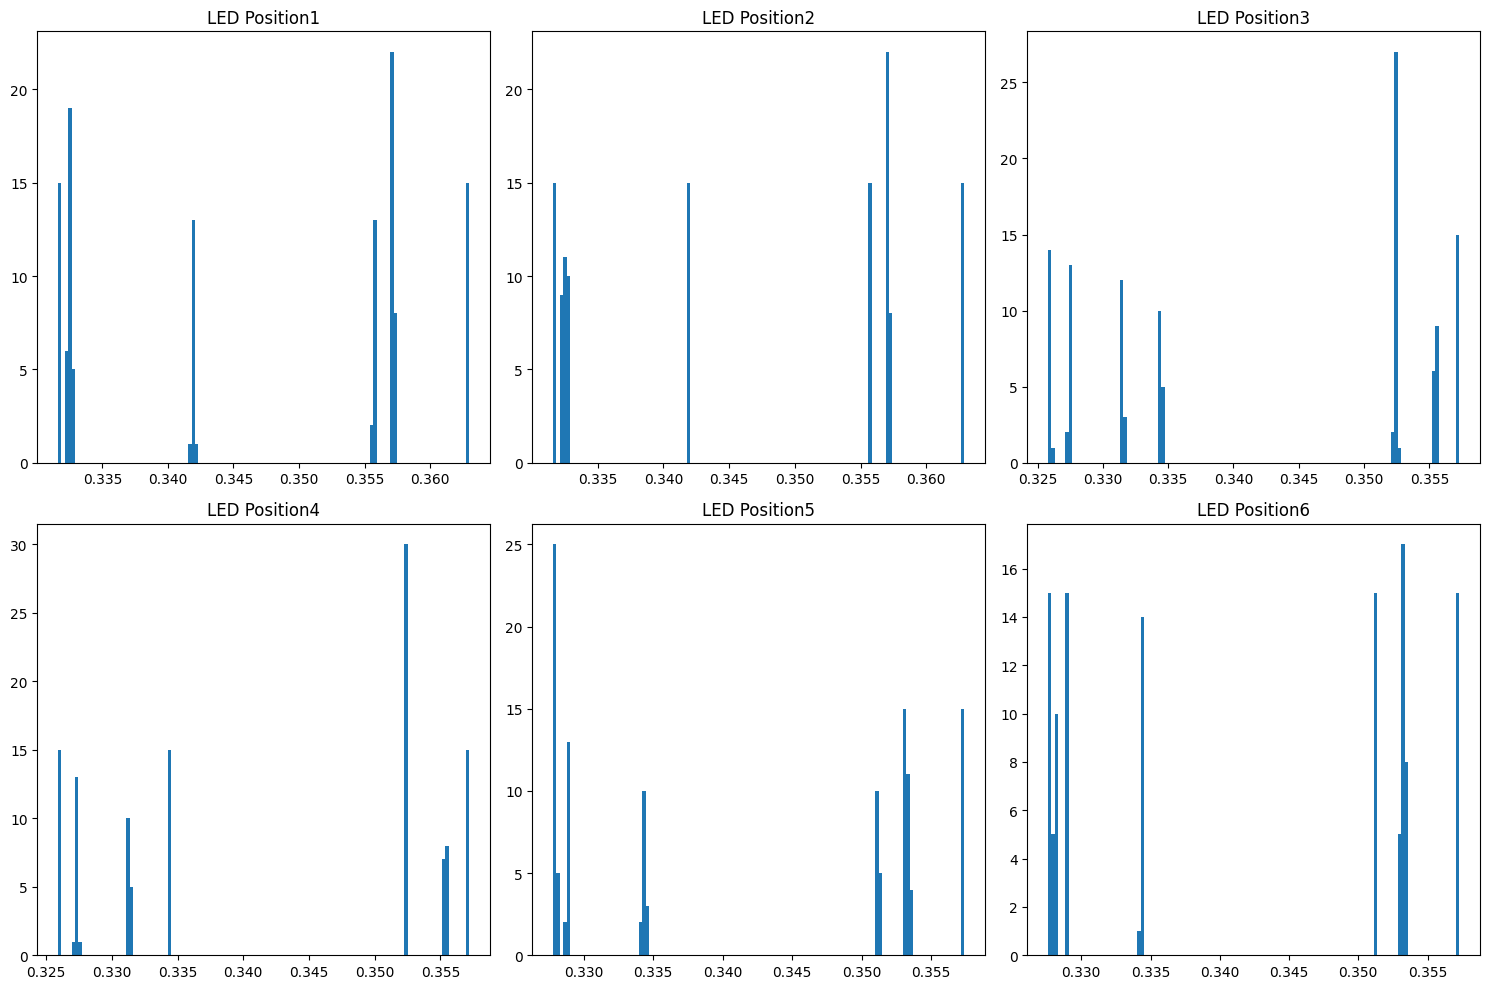

In [22]:
array = MEAS.values #Creates a ndarray with the values of the dataframe
positions = []
for i, position in enumerate(range(glob.leds_per_nest*2)):
    position = array[i::glob.leds_per_nest*2].reshape(-1, 1)
    positions.append(position)
values_per_position = result_array = np.concatenate(positions, axis=1).reshape(glob.leds_per_nest*2, -1)
fig, axes = plt.subplots(int(glob.leds_per_nest*2/3), 3, figsize=(15, 10)) #subplots
for i in range(6): #Subplots definitions
    row, col = divmod(i, 3)
    ax = axes[row, col]
    ax.hist(values_per_position[i, :], 120)
    ax.set_title(f'LED Position{i+1}')
plt.tight_layout()
plt.show()

Filtering

![title](../media/Z-score.jpg)

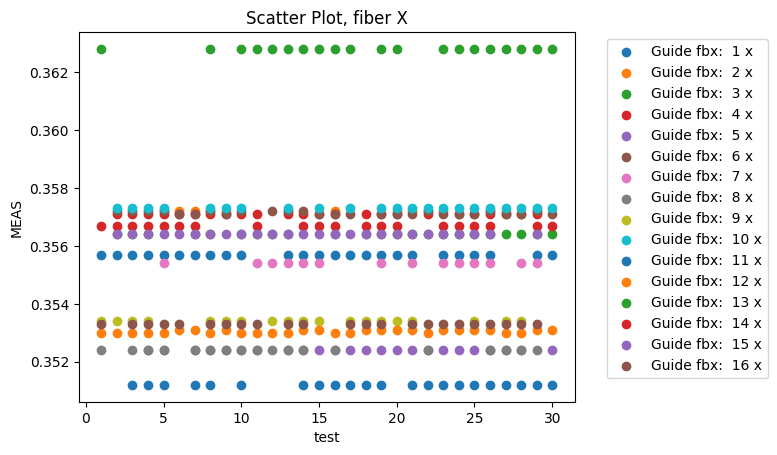

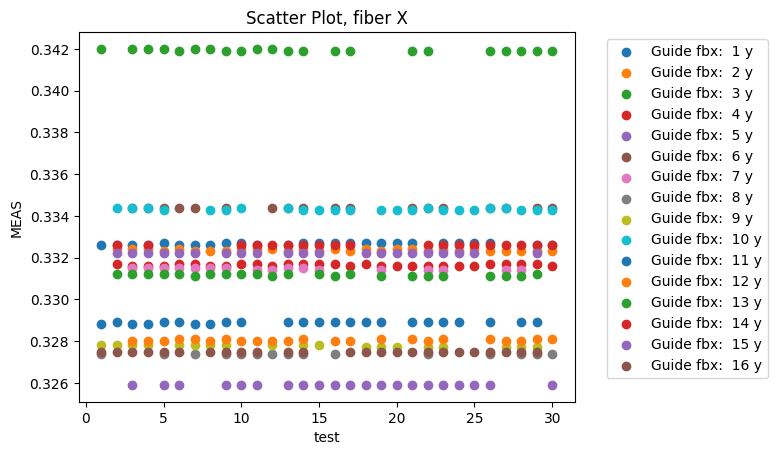

In [23]:
#Filter values by their row z-score
z_df = z_score_filter(df_plus_limits, 1)
#Plot the filtered values
plot_scatter(z_df.iloc[:, :-2], 'Scatter Plot, fiber X', 'test', 'MEAS', 'Guide fbx: ', filter='x')
plot_scatter(z_df.iloc[:, :-2], 'Scatter Plot, fiber X', 'test', 'MEAS', 'Guide fbx: ', filter='y')

In [24]:
#Split the dataframe for x fiber and y fiber
x_fiber = z_df[z_df.index % 2 == 0]
y_fiber = z_df[z_df.index % 2 != 0]
#Calculate the new RyR
RyRx_filtered, RyRy_filtered = RyR(z_df)

RyR Guide fbx 1: 0.0 % Status: Correct
RyR Guide fbx 2: 0.0 % Status: Correct
RyR Guide fbx 3: 0.0 % Status: Correct
RyR Guide fbx 4: 0.0 % Status: Correct
RyR Guide fbx 5: 0.0 % Status: Correct
RyR Guide fbx 6: 1.012739367084118 % Status: Correct
RyR Guide fbx 7: 1.1521328816827464e-12 % Status: Correct
RyR Guide fbx 8: 1.1424100674951079e-12 % Status: Correct
RyR Guide fbx 9: 1.1406457265696489e-12 % Status: Correct
RyR Guide fbx 10: 2.2726989877559922e-12 % Status: Correct
RyR Guide fbx 11: 3.4090484816339883e-12 % Status: Correct
RyR Guide fbx 12: 1.017095255431669 % Status: Correct
RyR Guide fbx 13: 1.1351749721234438e-12 % Status: Correct
RyR Guide fbx 14: 0.0 % Status: Correct
RyR Guide fbx 15: 1.1322097734007363e-12 % Status: Correct
RyR Guide fbx 16: 1.1351749721234438e-12 % Status: Correct

RyR Guide fby 1: 1.0076629473114476 % Status: Correct
RyR Guide fby 2: 1.0170952554311041 % Status: Correct
RyR Guide fby 3: 0.9847319278351009 % Status: Correct
RyR Guide fby 4: 1.0170952

In [25]:
##Add both RyR to the database
confirmation = input("Do you want to export the new RyR to your database? (y/n): ").strip().lower()
if confirmation == 'y':
    RYR = pd.concat([RyRx, RyRy], axis=0).reset_index(drop=True)
    RYR_filtered = pd.concat([RyRx_filtered, RyRy_filtered], axis=0).reset_index(drop=True)
    prepare_database(RYR, glob.tooling+"_RyR") #Store a df inside the database of the project
    prepare_database(RYR_filtered, glob.tooling+"_RyR_filtered") #Store a df inside the database of the project
else:
    print("Operation canceled.")

../database/database.db found.
Dataframe stored as *PASSAT_B9_RyR*
../database/database.db actual contents:
    PASSAT_B9
    PASSAT_B9_limits
    PASSAT_B9_RyR
../database/database.db found.
Dataframe stored as *PASSAT_B9_RyR_filtered*
../database/database.db actual contents:
    PASSAT_B9
    PASSAT_B9_limits
    PASSAT_B9_RyR
    PASSAT_B9_RyR_filtered
